# Deep Fruit Vision Evaluation

Our detection, ripeness, and defect models are all trained and tested on different datasets. This notebook evaluates the overall performance of Deep Fruit Vision on a unique, hand-labelled test dataset.

In [1]:
import os
import shutil

from tqdm.notebook import tqdm
import torch
from torch.utils.data import Subset
from deepfruitvision import DeepFruitVision
from modules.datasets import EnsembleDataset, save_dataset
from yolov5.val import process_batch

import matplotlib
from matplotlib import pyplot as plt

import numpy as np

%matplotlib inline

In [2]:
best_classification_weights = os.path.join('weights', 'detection', 'best_classification.pt')
best_detection_weights = os.path.join('weights', 'detection', 'best_detection.pt')
ripeness_weights = os.path.join('weights', 'ripeness', 'ripeness_model_fine_tuned')
defect_weights = os.path.join('weights', 'defect', 'defect_model_fine_tuned')

We can use the EnsembleDataset class to easily load images and labels from the test dataset. We reserve a bit of the ensemble dataset for fine-tuning our models. We use the seed to make sure that we get the same images across runs.

In [3]:
eval_dir = os.path.join('dataset', 'deepfruitvision_eval')
detection_eval_img_dir = os.path.join(eval_dir, 'images')
detection_eval_label_dir = os.path.join(eval_dir, 'labels')

os.makedirs(detection_eval_img_dir, exist_ok=True)
os.makedirs(detection_eval_label_dir, exist_ok=True)

seed = 123
np.random.seed(seed)
num_fine_tune_samples = 50

In [4]:
ensemble_dataset = EnsembleDataset('dataset', for_yolov5=True)

random_indices = np.random.permutation(len(ensemble_dataset))
fine_tune_indices = random_indices[:num_fine_tune_samples]
test_indices = random_indices[num_fine_tune_samples:]

In [5]:
yolov5_test_dataset = Subset(ensemble_dataset, test_indices)
save_dataset(yolov5_test_dataset, detection_eval_img_dir, detection_eval_label_dir) # save the test split of the ensemble dataset with Yolo-v5 labels to the disk

ensemble_dataset.for_yolov5 = False
deepfruitvision_test_dataset = Subset(ensemble_dataset, test_indices) # then just get the test split of the ensemble dataset

Saving dataset to dataset\deepfruitvision_eval\images and dataset\deepfruitvision_eval\labels: 100%|██████████| 105/105 [00:01<00:00, 98.88it/s]


## Detection mAP

The detection/Yolo-v5 model is responsible for detecting and classifying fruits, so we can just use Yolo-v5's built-in evaluation script. We've provided two Yolo-v5 models. One is better at detecting fruits (high bounding box accuracy, but has difficulty classifying fruits) and the other is better at classification (better at classifying fruits, but has less accurate bounding boxes). We'll evaluate both models and compare their performances.

The following two tests are each Yolo-v5 model on the detection and classification task.

In [6]:
%run yolov5/val.py --data fine_tune_apple_papaya_mango.yaml --weights {best_detection_weights} --img 416 --task test

val: data=fine_tune_apple_papaya_mango.yaml, weights=['weights\\detection\\best_detection.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5\runs\val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5  2022-11-21 Python-3.10.5 torch-1.12.0 CUDA:0 (NVIDIA GeForce GTX 1070, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning C:\Users\jorda\Documents\School\CMPE 295\fruit-detection\dataset\deepfruitvision_eval\labels... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 00:05
test: New cache created: C:\Users\jorda\Documents\School\CMPE 295\fruit-detection\dataset\deepfruitvision_eval\labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 4/4 00:04
           

<Figure size 432x288 with 0 Axes>

In [6]:
%run yolov5/val.py --data fine_tune_apple_papaya_mango.yaml --weights {best_classification_weights} --img 416 --task test

val: data=fine_tune_apple_papaya_mango.yaml, weights=['weights\\detection\\best_classification.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5\runs\val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5  2022-11-21 Python-3.10.5 torch-1.12.0 CUDA:0 (NVIDIA GeForce GTX 1070, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning C:\Users\jorda\Documents\School\CMPE 295\fruit-detection\dataset\deepfruitvision_eval\labels... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 00:05
test: New cache created: C:\Users\jorda\Documents\School\CMPE 295\fruit-detection\dataset\deepfruitvision_eval\labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 4/4 00:03
      

<Figure size 432x288 with 0 Axes>

The `best classification` appears to do much better than the 'best detection' weights, but that's because it often mixed up the classes. If we ignore the classes and just judge the models by detection performance, we can see how good the `best detection` model is at fruit detection.

In [4]:
%run yolov5/val.py --data fine_tune_apple_papaya_mango.yaml --weights {best_detection_weights} --img 416 --task test --single-cls

val: data=fine_tune_apple_papaya_mango.yaml, weights=['weights\\detection\\best_detection.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=True, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5\runs\val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5  2022-11-21 Python-3.10.5 torch-1.12.0 CUDA:0 (NVIDIA GeForce GTX 1070, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning C:\Users\jorda\Documents\School\CMPE 295\fruit-detection\dataset\deepfruitvision_eval\labels.cache... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 00:00
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 4/4 00:03
                   all        105        417      0.787      0.835      0.878      0.651
Speed: 0.3ms pre-process, 5.2ms inference

<Figure size 432x288 with 0 Axes>

In [6]:
%run yolov5/val.py --data fine_tune_apple_papaya_mango.yaml --weights {best_classification_weights} --img 416 --task test --single-cls

val: data=fine_tune_apple_papaya_mango.yaml, weights=['weights\\detection\\best_classification.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=True, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5\runs\val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5  2022-11-21 Python-3.10.5 torch-1.12.0 CUDA:0 (NVIDIA GeForce GTX 1070, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning C:\Users\jorda\Documents\School\CMPE 295\fruit-detection\dataset\deepfruitvision_eval\labels.cache... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 00:00
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 4/4 00:02
                   all        105        417       0.86        0.9      0.938       0.72
Speed: 0.3ms pre-process, 5.5ms infe

<Figure size 432x288 with 0 Axes>

And now we can clean the Yolov5 eval dir because we don't need it any more.

In [7]:
# also, clean up the yolov5 eval dataset
shutil.rmtree(eval_dir)

## Ensemble Classification Accuracy

Now we want to evaluate the accuracy of the ensemble classification model. Since we only care about the accuracy of the harvestability, we ignore any bounding box that is too small to be classified. We will use the 'best_detection_weights' for this task because we care more about localizing the frui than accurately classifying it.

In [11]:
fruit_vision = DeepFruitVision(best_classification_weights, ripeness_weights, defect_weights)

YOLOv5  2022-11-21 Python-3.10.5 torch-1.12.0 CUDA:0 (NVIDIA GeForce GTX 1070, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


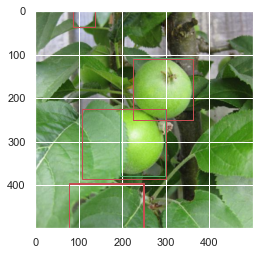

In [12]:
# use Matplotlib to display the true and predicted bounding boxes
# true bounding boxes are a list of dicts with x, y, w, and h keys (all normalized, not pixel values)
# predicted bounding boxes are a list of dicts with xmin, ymin, xmax, ymax (all normalized, not pixel values)
def display_bboxes(img, true_bboxes, pred_bboxes):
    img_h, img_w, _ = img.shape
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for bbox in true_bboxes:
        x = bbox['x'] * img_w
        y = bbox['y'] * img_h
        w = bbox['w'] * img_w
        h = bbox['h'] * img_h
        rect = matplotlib.patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    for bbox in pred_bboxes:
        x = bbox['xmin'] * img_w
        y = bbox['ymin'] * img_h
        w = (bbox['xmax'] - bbox['xmin']) * img_w
        h = (bbox['ymax'] - bbox['ymin']) * img_h
        rect = matplotlib.patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

for i in range(1):
    img, true_boxes = deepfruitvision_test_dataset[i]
    pred_boxes = fruit_vision.get_harvestability(img)
    display_bboxes(img, true_boxes, pred_boxes)

In [13]:
min_box_size = fruit_vision.min_bounding_box_size

total_boxes = 0
total_correct = 0

for frame, true_boxes in tqdm(deepfruitvision_test_dataset, desc='Evaluating DeepFruitVision', total=len(deepfruitvision_test_dataset)):
    predicted_boxes = fruit_vision.get_harvestability(frame)

    # ignore any boxes in the predicted and true boxes that are too small to be classified
    predicted_boxes = [box for box in predicted_boxes if box['xmax'] - box['xmin'] > min_box_size and box['ymax'] - box['ymin'] > min_box_size]
    # the true boxes are numpy arrays with the format [class, x, y, w, h, ...]
    true_boxes = [box for box in true_boxes if box['w'] > min_box_size and box['h'] > min_box_size]

    if len(true_boxes) == 0: # if there are no boxes large enough to be classified, then we can't evaluate this frame
        continue

    total_boxes += len(true_boxes)

    if len(predicted_boxes) == 0: # if there are no predicted boxes, then we automatically get 0 correct
        continue
    
    # now we have to convert the predicted and true boxes to tensors so we can use Yolo-v5's process_batch function
    # the predicted boxes need to be converted to a tensor of shape [num_boxes, 6] with the format [ x1, y1, x2, y2, conf, class] ...
    predicted_boxes = torch.tensor([[box['xmin'], box['ymin'], box['xmax'], box['ymax'], box['conf'], box['harvestability']] for box in predicted_boxes])

    # ... and the true boxes need to be converted to a tensor of shape [num_boxes, 5] with the format [class, x1, y1, x2, y2]
    true_boxes = torch.tensor([[box['ensemble'], box['x'], box['y'], box['x'] + box['w'], box['y'] + box['h']] for box in true_boxes])

    correct_boxes = process_batch(predicted_boxes, true_boxes, torch.tensor([.5]))

    total_correct += torch.sum(correct_boxes).item()

print(f'Got {total_correct} out of {total_boxes} correct ({total_correct / total_boxes * 100:.2f}%)')

Evaluating DeepFruitVision: 100%|██████████| 105/105 [00:51<00:00,  2.05it/s]

Got 95 out of 338 correct (28.11%)
